In [1]:
####################
#
# A small notebook to analyze the results obtained
# used the models trained previously
# Please make sure to follow the configuration steps
# detailled in the readme.md to ensure that you are
# using the right datasets and models
# 
####################

In [2]:
####################
#
# Initialization
#
####################

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch

from drawinganalyses.config import (
    LOCAL_DATA_DIR,
    DATASET_NAME,
    MODELS_STORAGE,
    ANNOTATION_FILE,
    MODEL_NAME,
    label_to_str
)
from drawinganalyses.datasets.drawings_pytorch import DrawingDataset
from drawinganalyses.utils.visualization import imshow, visualize_model

cudnn.benchmark = True
plt.ion()   # interactive mode

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Some parameters for our loaders

# Putting it here because of transforms.Resize()
# However, the anti-aliases parameter should be addressed in the future
# For now, it induces a bug in the masks for Captum
import warnings
warnings.filterwarnings("ignore")


batch_size=4
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((256, 256),)])

In [4]:
generator1 = torch.Generator().manual_seed(42) # Seed fixed for reproducibility
dataset = DrawingDataset(
    dataset_name=DATASET_NAME,
    annotations_file=ANNOTATION_FILE,
    data_dir=LOCAL_DATA_DIR,
    label_to_str=label_to_str,
    transform=transform)
# Splitting into train, valid, test randomly (but fixed since seed is fixed)
trainset, valset, testset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator1)

In [5]:
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)
valloader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=1,
    shuffle=True,
    num_workers=2)

dataloaders={'train':trainloader, 'val':valloader, 'test':testloader}
dataset_sizes={'train':len(trainloader)*batch_size, 'val':len(valloader)*batch_size, 'test':len(testloader)*batch_size}


In [6]:
# Some useful parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names = list(label_to_str.values())


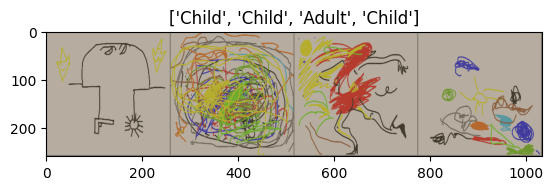

In [7]:
# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Show the data and the labels
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Loading of the pretrained model

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
model.load_state_dict(torch.load(MODELS_STORAGE / MODEL_NAME))
model.eval()

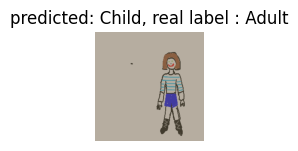

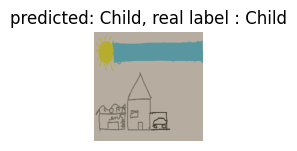

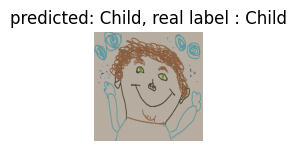

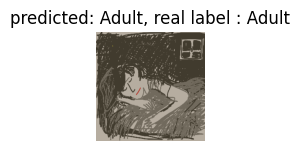

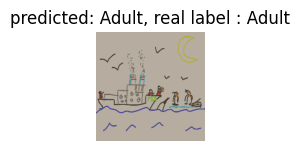

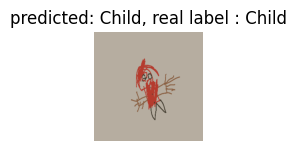

In [9]:
# Visualisation of a few inference from the model
visualize_model(model, device, dataloaders, class_names, label_to_str, num_images=6)

In [10]:
####################
#
# Captum
#
####################

# This section is used to illustrate a few possibilities offered by Captum to analyze the result obtained using our trained model
# More information : https://captum.ai/

In [11]:
# Inference and formating of an example from the test set

inputs, labels, _ = next(iter(testloader))
true_label = label_to_str[labels.item()]
output = model(inputs)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = class_names[(pred_label_idx.item())]

In [12]:
# From here on : applying different explainability technics to this drawing

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(inputs, target=pred_label_idx, n_steps=200)

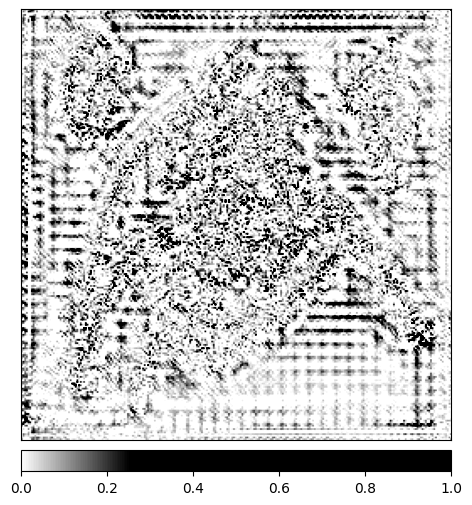

In [13]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

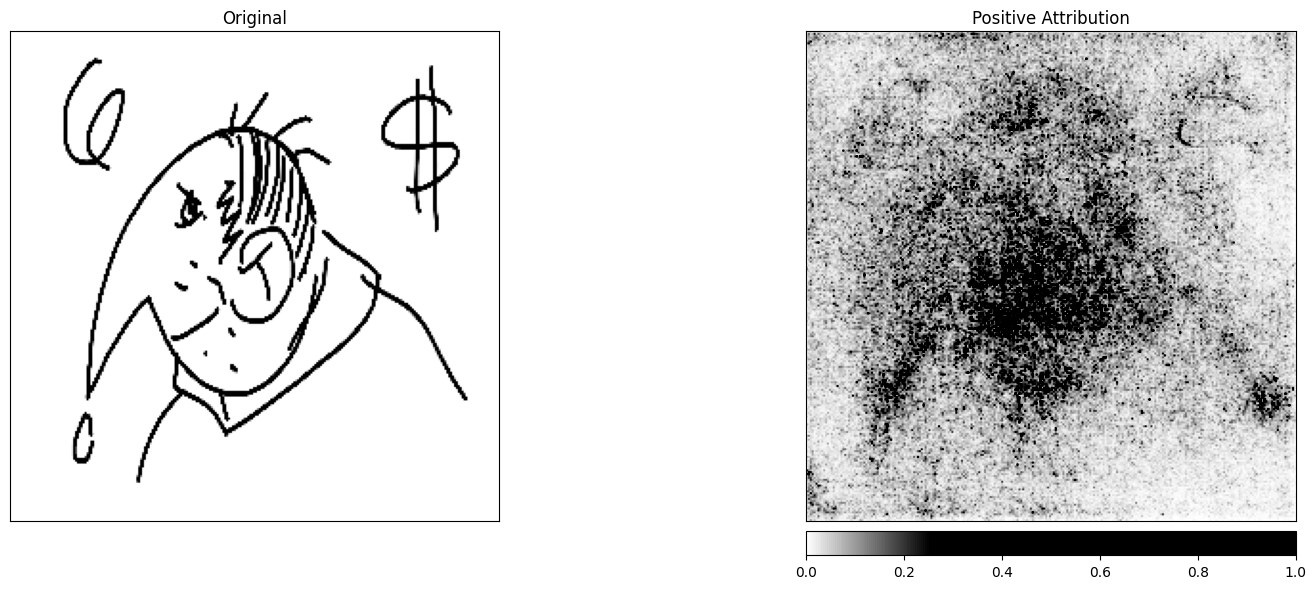

In [14]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(inputs, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution"],
                                      fig_size=(18, 6))


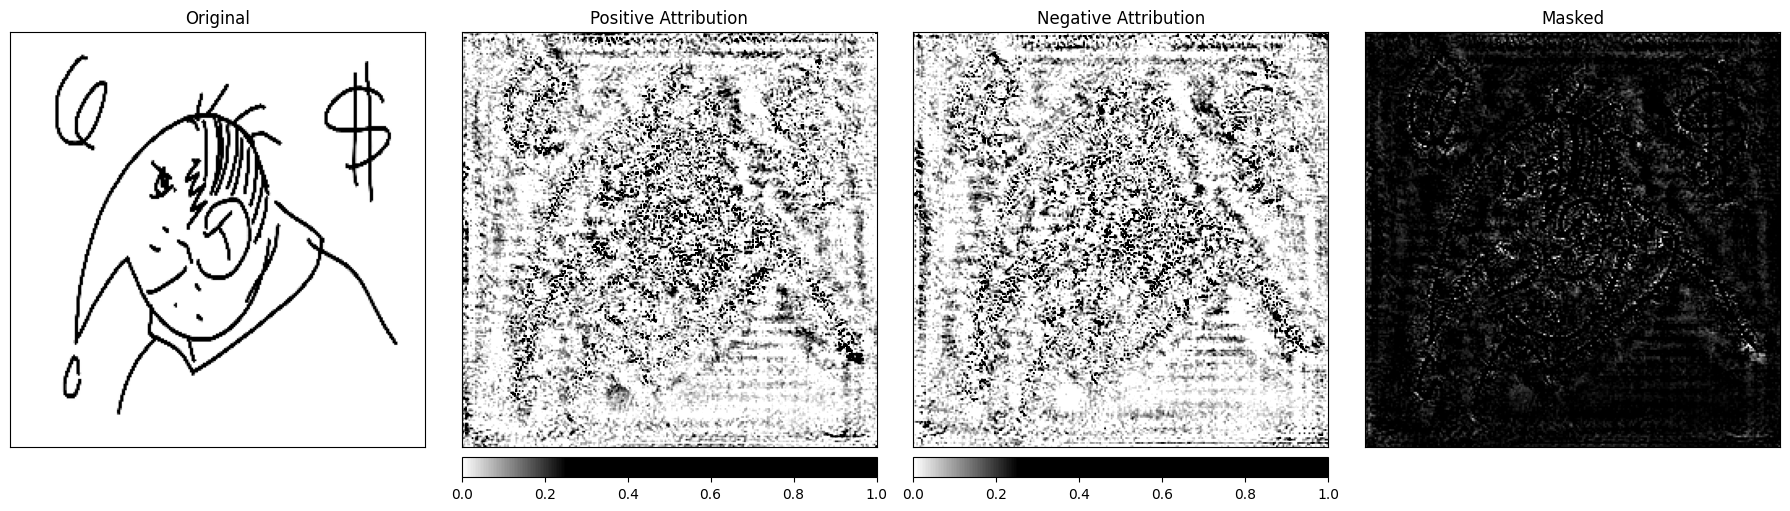

In [15]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([inputs * 0, inputs * 1])

attributions_gs = gradient_shap.attribute(inputs,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))


In [16]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(inputs,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


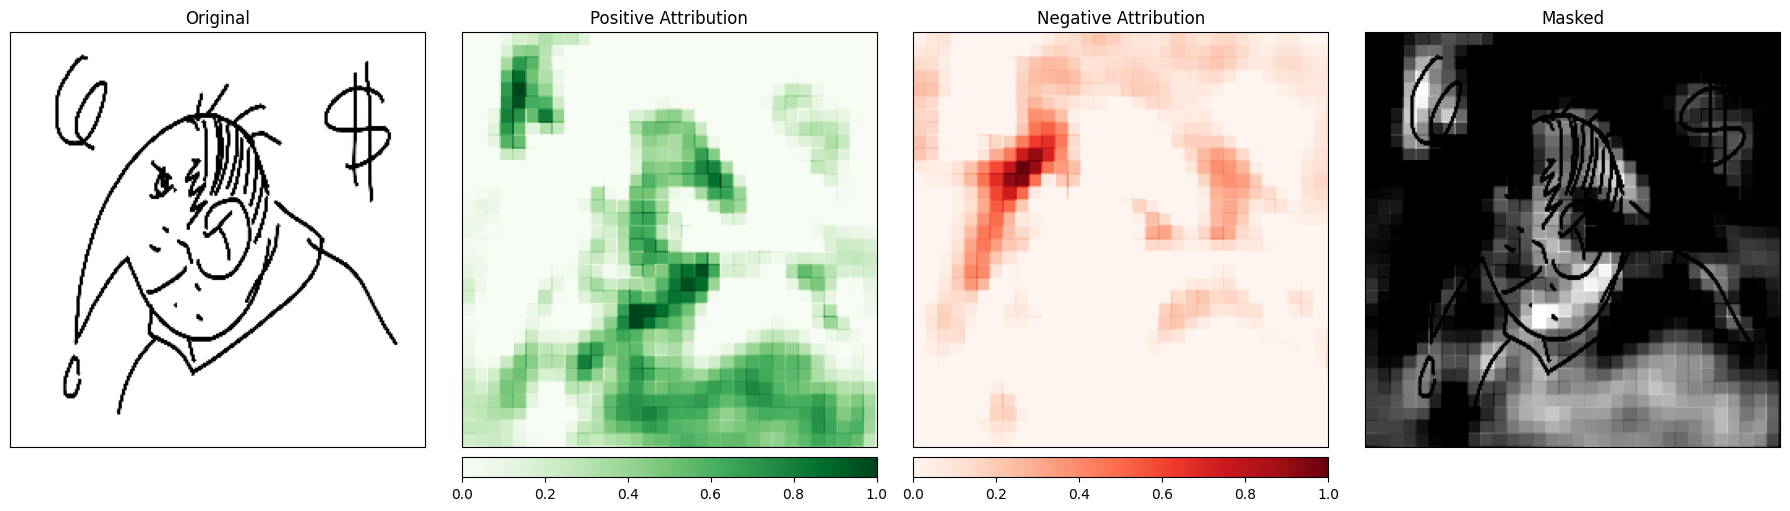

In [17]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )


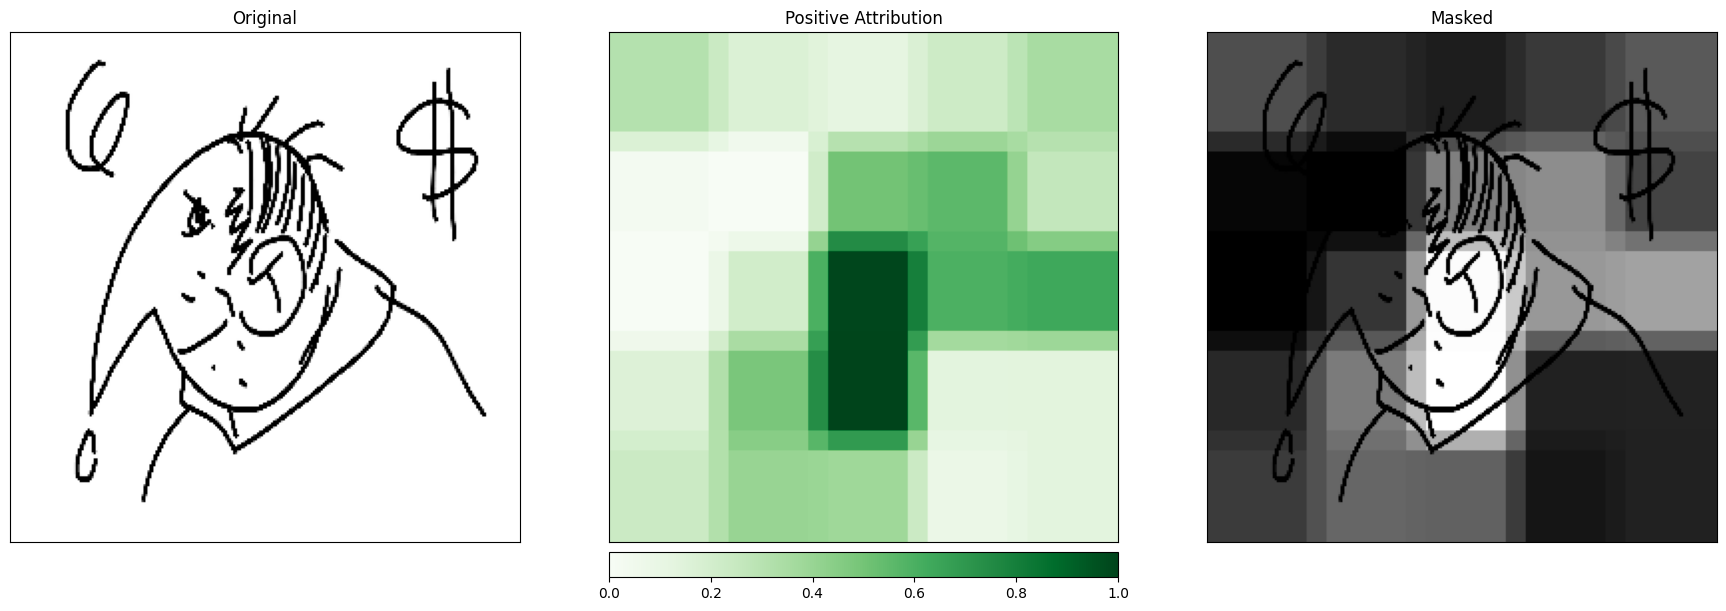

In [18]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(inputs,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )
